In [6]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:

ordered_layer_names = {
 0: 'conv_seqs',
 1: 'conv_seqs.0',
 2: 'conv_seqs.0.conv',
 3: 'conv_seqs.0.max_pool2d',
 4: 'conv_seqs.0.res_block0',
 5: 'conv_seqs.0.res_block0.conv0',
 6: 'conv_seqs.0.res_block0.conv1',
 7: 'conv_seqs.0.res_block1',
 8: 'conv_seqs.0.res_block1.conv0',
 9: 'conv_seqs.0.res_block1.conv1',
 10: 'conv_seqs.1',
 11: 'conv_seqs.1.conv',
 12: 'conv_seqs.1.max_pool2d',
 13: 'conv_seqs.1.res_block0',
 14: 'conv_seqs.1.res_block0.conv0',
 15: 'conv_seqs.1.res_block0.conv1',
 16: 'conv_seqs.1.res_block1',
 17: 'conv_seqs.1.res_block1.conv0',
 18: 'conv_seqs.1.res_block1.conv1',
 19: 'conv_seqs.2',
 20: 'conv_seqs.2.conv',
 21: 'conv_seqs.2.max_pool2d',
 22: 'conv_seqs.2.res_block0',
 23: 'conv_seqs.2.res_block0.conv0',
 24: 'conv_seqs.2.res_block0.conv1',
 25: 'conv_seqs.2.res_block1',
 26: 'conv_seqs.2.res_block1.conv0',
 27: 'conv_seqs.2.res_block1.conv1',
 28: 'hidden_fc',
 29: 'logits_fc',
 30: 'value_fc'
}


In [ ]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()



    unchanged_obs= venv.reset()
    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()


    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
    # Load model and calculate steering vector
    model = helpers.load_model(model_path=model_path)
    print(layer_number)
    print(ordered_layer_names[layer_number])
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]


    # Run episode with steering
    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    helpers.plot_single_observation(observations_steering[-1])

    return total_reward_steering


model_path = "../model_9501.0.pt"
modification_value = -2
total_episodes = 200
best_layer = None
best_score = 0
layer_number = 14

# for layer_number in range(14):  # Adjusted range to be between 1 and 29 inclusive
count_rewards_0 = 0
for episode in range(total_episodes):
    filepath=f'episode_steering_{episode}.gif'
    total_reward_steering = run_gem_steering_experiment(model_path, layer_number, modification_value, save_gif=False)
    print(total_reward_steering)
    if total_reward_steering == 0:
        count_rewards_0 += 1
# print(f"Layer {ordered_layer_names[layer_number]}, {layer_number}: Number of times total reward steering was 0: {count_rewards_0}/{total_episodes}")
# if count_rewards_0 > best_score:
#     best_score = count_rewards_0
#     best_layer = layer_number

print(f"Count rewards 0 out of total episodes: {count_rewards_0}/{total_episodes}")

    

In [115]:
def run_episode_with_steering_and_check_target_acquisition(env, model, steering_vector, steering_layer, modification_value,filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames=[]
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    print(lock_positions_before)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer,modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)
    
        state = heist.state_from_venv(env, 0)
        
        # state_bytes = state.state_bytes
        
        # if not done:
        #     state = heist.state_from_venv(env, 0)
        #     full_grid = state.full_grid(with_mouse=False)
        #     entities = state.state_vals["ents"]
        #     legal_positions = heist.get_legal_mouse_positions(full_grid, entities)

        # print(lock_positions_before, lock_positions_after)
        # if lock_positions_before != lock_positions_after:
        #     num_changes_counted +=1
        # lock_positions_before = lock_positions_after
        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break
    
    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)
        print(f"Saved gif to {filepath}")
    
    helpers.plot_single_observation(helpers.tensor_to_image(observation))

    # state = heist.state_from_venv(env, 0)

    # state_vals = state.state_vals
    # lock_positions_after = heist.get_lock_statuses(state_vals)
    # if num_changes_counted == num_changes_expected and total_reward == 0: return True
    if total_reward == 0: return True

    else: return False

[{'x': StateValue(val=3.5, idx=13939), 'y': StateValue(val=4.5, idx=13943), 'vx': StateValue(val=0.0, idx=13947), 'vy': StateValue(val=0.0, idx=13951), 'rx': StateValue(val=0.5, idx=13955), 'ry': StateValue(val=0.5, idx=13959), 'type': StateValue(val=1, idx=13963), 'image_type': StateValue(val=1, idx=13967), 'image_theme': StateValue(val=0, idx=13971), 'render_z': StateValue(val=0, idx=13975), 'will_erase': StateValue(val=0, idx=13979), 'collides_with_entities': StateValue(val=0, idx=13983), 'collision_margin': StateValue(val=0.0, idx=13987), 'rotation': StateValue(val=0.0, idx=13991), 'vrot': StateValue(val=0.0, idx=13995), 'is_reflected': StateValue(val=0, idx=13999), 'fire_time': StateValue(val=-1, idx=14003), 'spawn_time': StateValue(val=-1, idx=14007), 'life_time': StateValue(val=0, idx=14011), 'expire_time': StateValue(val=-1, idx=14015), 'use_abs_coords': StateValue(val=0, idx=14019), 'friction': StateValue(val=1.0, idx=14023), 'smart_step': StateValue(val=0, idx=14027), 'avoids

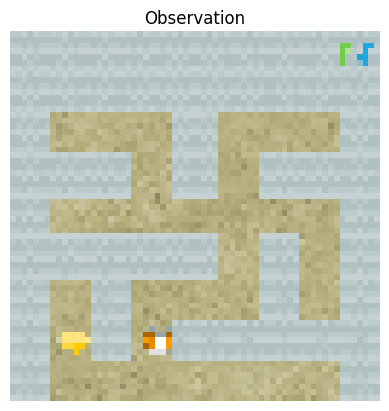

True

In [116]:

model_path = "../model_9501.0.pt"

model = helpers.load_model(model_path=model_path)
layer_number = 14
start_level = random.randint(1, 10000)
save_gif = False
episode_timeout = 200
num_levels=1
venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)

start_level = random.randint(1, 10000)
venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
state = heist.state_from_venv(venv, 0)
unchanged_obs = venv.reset()



unchanged_obs= venv.reset()
state_values = state.state_vals

for ents in state_values["ents"]:
    if ents["image_type"].val== 9:
        gem_x = ents["x"].val 
        gem_y = ents["y"].val 

state.remove_gem()


state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs = venv.reset()

state = heist.state_from_venv(venv, 0)

state.set_gem_position(gem_y-.5,gem_x-.5)

state_bytes = state.state_bytes

if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
# Load model and calculate steering vector
model = helpers.load_model(model_path=model_path)
layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)

model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()
output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
model_activations.clear_hooks()
output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)

steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

run_episode_with_steering_and_check_target_acquisition(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_locks.gif',
        save_gif=False, episode_timeout=episode_timeout
    )

In [ ]:
lock_positions_before = helpers.get_lock_positions(state)


In [20]:
lock_positions_after

NameError: name 'lock_positions_after' is not defined

In [49]:

classified_dataset = heist.create_classified_dataset(num_samples_per_category=900, num_levels=0)